In [58]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import arch as arch
from arch import arch_model

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

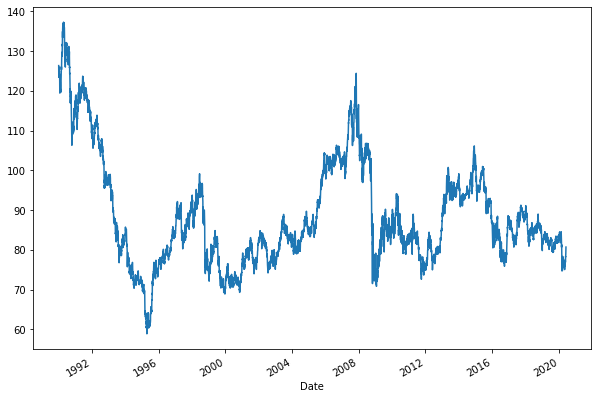

In [5]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(10,7))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Chart shows high volatility. In shorterm there are some periods where there is a trend (either descending from 19192 to 1996) followed by sudden reversal of thrend to the upside (from 1996 to 2000) and this pattern then repeats in 2000 -2001 (sudden towntrend) to 2004-2008 (uptreand) followed again by sudden crash. Overall the chart never reached it previous highs , but also did not crash to its previous lows.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [7]:


# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])
ts_trend.head()

Date
1990-01-02    125.850905
1990-01-03    125.679684
1990-01-04    125.508788
1990-01-05    125.338304
1990-01-08    125.167037
Name: Price_trend, dtype: float64

In [10]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_df_timeseries = cad_jpy_df['Price'].to_frame()
cad_jpy_df_timeseries['noise'] = ts_noise.to_frame()
cad_jpy_df_timeseries['trend'] = ts_trend.to_frame()
cad_jpy_df_timeseries.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:xlabel='Date'>

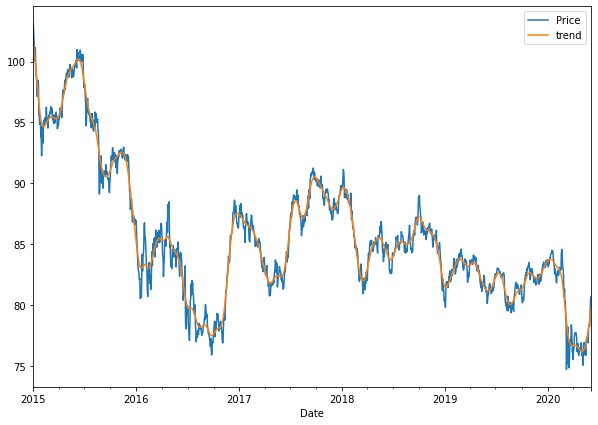

In [14]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_df_timeseries_2015 = cad_jpy_df_timeseries.loc["2015-01-01":, ["Price","trend"]]
cad_jpy_df_timeseries_2015.plot(figsize=(10,7))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** There is a lot of volatility over the time period.The price movements are usually significant during begining and end of the year e.g (it crashed at begining of 2016, then there is huge spike at begining of 2017, and again at end of 2018 there is a huge drop. Similarly it has a huge increase in begining of 2018 and huge drop at end of 2018. Same behaviour is observers at begining of 2019 where there is a significant recovery, followed by a significant drop at begining of 2020)

Chart shows downtrend due to lower highs and lower lows.

<AxesSubplot:xlabel='Date'>

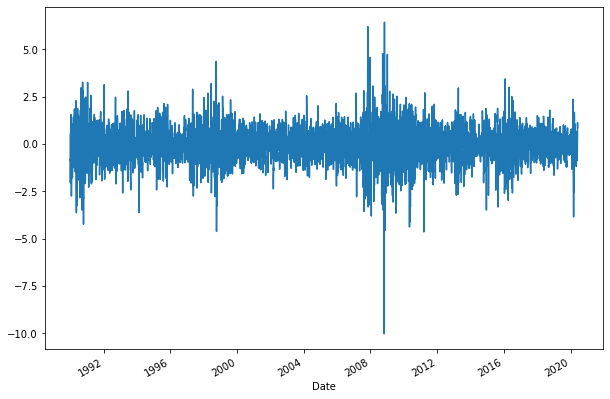

In [31]:
# Plot the Settle Noise
cad_jpy_df_timeseries['noise'].plot(figsize=(10,7))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [35]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [36]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23010D+00    |proj g|=  3.45590D-04

At iterate    5    f=  1.23010D+00    |proj g|=  3.57714D-05

At iterate   10    f=  1.23010D+00    |proj g|=  3.51541D-04

At iterate   15    f=  1.23007D+00    |proj g|=  7.78044D-05

At iterate   20    f=  1.23007D+00    |proj g|=  1.55431D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   4.441D-08   1.230D+00
  F =   1.2300678291598384     

CONVERG

In [38]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 30 Apr 2022   AIC                          19513.955
Time:                        18:21:37   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1705           +0.0000j           42.1705            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

ADF Statistic: -2.983688
p-value:        0.036446 
Lags used:      17
Critical Values:
('1%', -3.4311768768960773)
('5%', -2.8619054197754936)
('10%', -2.566964508289118)


True

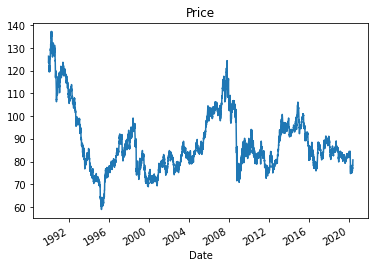

In [45]:

def is_stationary(series_x): 
    """
    Input expected: Pandas series
    """
    series_x.plot(title=series_x.name)
    
    result = adfuller(series_x)
    # Access the contents of the results:
    print('ADF Statistic: %f' % result[0])
    print('p-value:        %f ' % result[1])
    print('Lags used:      %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print((key, value))
    

    p_value = result[1]
    if p_value <= 0.05: 
        return True 
    elif p_value > 0.05: 
        return False

#is_stationary(cad_jpy_df['Price'])

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

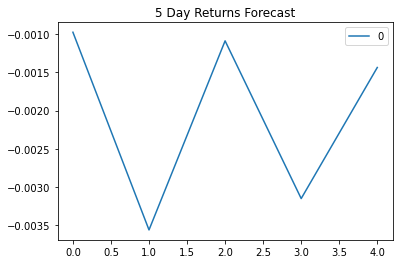

In [46]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")


**Question:** Based on the p-value, is the model a good fit?

**Answer:** The p-value is varies a lot from 0 to more than 0.05, so the model is not very accurate to predict forecast

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [49]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model_arima = ARIMA(cad_jpy_df['Price'], order=(5, 1, 1))

# Fit the model
results_arima = model_arima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10313D+00    |proj g|=  1.92979D-04

At iterate    5    f=  1.10313D+00    |proj g|=  5.81757D-06

At iterate   10    f=  1.10313D+00    |proj g|=  3.35287D-05


 This problem is unconstrained.



At iterate   15    f=  1.10313D+00    |proj g|=  4.79616D-05

At iterate   20    f=  1.10313D+00    |proj g|=  5.77316D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     27      1     0     0   8.882D-08   1.103D+00
  F =   1.1031309576181250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [50]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Sat, 30 Apr 2022   AIC                          17507.244
Time:                        20:57:34   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

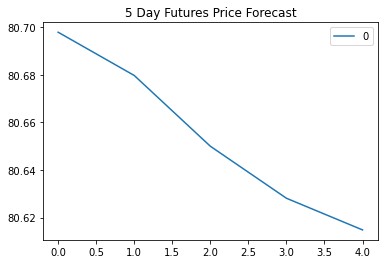

In [52]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The p-value is consistently higher than 0.05, so the model is not very accurate to predict forecast. But as per the forecast, the Yen could go down in value in near term

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [57]:
# Estimate a GARCH model:

model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
res_garch = model_garch.fit(disp="off")

In [59]:
# Summarize the model results
res_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17828.0
Method:            Maximum Likelihood   BIC:                           17849.0
                                        No. Observations:                 7928
Date:                Sat, Apr 30 2022   Df Residuals:                     7928
Time:                        21:14:55   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.0734e-03  2.401e-03      3.779  1.574e-04 [4.368e-03,1.378e-02]
alpha[1]       0.0624  9.003e-03      6.936  4.036e-12 [4.480e-02,8.009e-02]
beta[1]        0.9243  1.110e-02     83.252      0.000     [  0.903,  0.946]
============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [61]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [62]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res_garch.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [63]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566047,12.573736,12.581319,12.588797,12.596172


In [64]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566047
h.2,12.573736
h.3,12.581319
h.4,12.588797
h.5,12.596172


<AxesSubplot:>

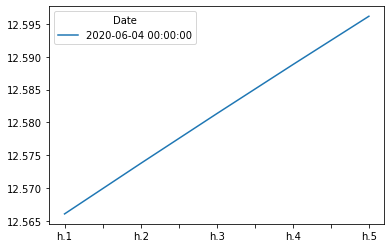

In [65]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Based on the model, the volatility will increase in the near term.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * I would not buy Yen to hold it for long term as the overall trend is downwads. It might be an option for trading as there is a high volatility and one can short/buy puts to make money by trading.

2. Is the risk of the yen expected to increase or decrease?
    * The future prediction models are not accurate, however based on the increase volatility which is accurate due to lower p-values, the risk is expected to increase

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * The volatility is expected to be very high, which can be beneficial for trading frequently using additional chart patterns.